In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [5]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
data = pd.read_csv("./stock_tweets.csv")
data
print(data.shape)

(80793, 4)


In [7]:
data2 = pd.read_csv("./stock_yfinance_data.csv")
print(data2.shape)


(6300, 8)


In [8]:
data2

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [9]:

sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sia.polarity_scores(text)['compound']

data['Sentiment_Score'] = data['Tweet'].apply(get_sentiment_scores)


data.head()

,Date,Tweet,Stock Name,Company Name,Sentiment_Score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0772
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.0000
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.2960
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",-0.7568
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",-0.8750


In [10]:
data['Sentiment'] = data['Sentiment_Score'].apply(lambda score: 'Positive' if score > 0 else ('Neutral' if score == 0 else 'Negative'))

In [11]:
data['Date'] = pd.to_datetime(data['Date'])

data['Date'] = data['Date'].dt.strftime('%m-%d-%Y')
data.head()

,Date,Tweet,Stock Name,Company Name,Sentiment_Score,Sentiment
0,09-29-2022,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0772,Positive
1,09-29-2022,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.0000,Neutral
2,09-29-2022,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.2960,Positive
3,09-29-2022,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",-0.7568,Negative
4,09-29-2022,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",-0.8750,Negative


In [12]:
df = data[['Date', 'Stock Name','Company Name', 'Sentiment_Score','Sentiment']]


In [13]:
columns  = ['Sentiment']

In [14]:
dummy_df = pd.get_dummies(df, columns=columns)
dummy_df.head()

,Date,Stock Name,Company Name,Sentiment_Score,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,09-29-2022,TSLA,"Tesla, Inc.",0.0772,0,0,1
1,09-29-2022,TSLA,"Tesla, Inc.",0.0000,0,1,0
2,09-29-2022,TSLA,"Tesla, Inc.",0.2960,0,0,1
3,09-29-2022,TSLA,"Tesla, Inc.",-0.7568,1,0,0
4,09-29-2022,TSLA,"Tesla, Inc.",-0.8750,1,0,0


In [15]:
print(dummy_df.columns)

Index(['Date', 'Stock Name', 'Company Name', 'Sentiment_Score',
       'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive'],
      dtype='object')


In [16]:
dummy_df['Date'] = pd.to_datetime(dummy_df['Date'])

# Group by 'Date' and 'Stock Name' and aggregate the columns
aggregation = {
    'Sentiment_Score': ['mean', 'median', 'sum'],
    'Sentiment_Negative': 'sum',
    'Sentiment_Neutral': 'sum',
    'Sentiment_Positive': 'sum'
}

grouped_df = dummy_df.groupby(['Date', 'Stock Name']).agg(aggregation).reset_index()

# Flatten the MultiIndex columns
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]

# Rename columns for clarity
grouped_df.rename(columns={
    'Sentiment_Score_mean': 'Mean_Sentiment_Score',
    'Sentiment_Score_median': 'Median_Sentiment_Score',
    'Sentiment_Score_sum': 'Total_Sentiment_Score',
    'Sentiment_Negative_sum': 'Total_Sentiment_Negative',
    'Sentiment_Neutral_sum': 'Total_Sentiment_Neutral',
    'Sentiment_Positive_sum': 'Total_Sentiment_Positive'
}, inplace=True)
grouped_df.head()

,Date_,Stock Name_,Mean_Sentiment_Score,Median_Sentiment_Score,Total_Sentiment_Score,Total_Sentiment_Negative,Total_Sentiment_Neutral,Total_Sentiment_Positive
0,2021-09-30,AAPL,0.09890,0.2296,0.6923,2,1,4
1,2021-09-30,AMD,0.41780,0.4372,2.5068,0,2,4
2,2021-09-30,AMZN,0.24648,0.4515,1.2324,2,0,3
3,2021-09-30,DIS,0.54610,0.5461,0.5461,0,0,1
4,2021-09-30,GOOG,0.44040,0.4404,0.4404,0,0,1


In [17]:
stock_value = data2
sentiment_data = grouped_df

In [18]:
sentiment_data.rename(columns={'Date_': 'Date'}, inplace=True)
sentiment_data.rename(columns={'Stock Name_': 'Stock Name'}, inplace=True)

sentiment_data.head()

,Date,Stock Name,Mean_Sentiment_Score,Median_Sentiment_Score,Total_Sentiment_Score,Total_Sentiment_Negative,Total_Sentiment_Neutral,Total_Sentiment_Positive
0,2021-09-30,AAPL,0.09890,0.2296,0.6923,2,1,4
1,2021-09-30,AMD,0.41780,0.4372,2.5068,0,2,4
2,2021-09-30,AMZN,0.24648,0.4515,1.2324,2,0,3
3,2021-09-30,DIS,0.54610,0.5461,0.5461,0,0,1
4,2021-09-30,GOOG,0.44040,0.4404,0.4404,0,0,1


In [19]:
stock_value.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [20]:
stock_value['Date'] = pd.to_datetime(stock_value['Date'])
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])

combined = stock_value.merge(sentiment_data, how="left", on=["Date", "Stock Name"])


In [21]:
column_order = ['Date', 'Stock Name'] + [col for col in combined.columns if col not in ['Date', 'Stock Name']]
combined = combined[column_order]


In [22]:
combined.head()

,Date,Stock Name,Open,High,Low,Close,Adj Close,Volume,Mean_Sentiment_Score,Median_Sentiment_Score,Total_Sentiment_Score,Total_Sentiment_Negative,Total_Sentiment_Neutral,Total_Sentiment_Positive
0,2021-09-30,TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.231552,0.32820,20.8397,24.0,13.0,53.0
1,2021-10-01,TSLA,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.233704,0.22285,21.9682,15.0,28.0,51.0
2,2021-10-04,TSLA,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.135388,0.00000,16.1112,20.0,47.0,52.0
3,2021-10-05,TSLA,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.069445,0.00000,6.1112,29.0,22.0,37.0
4,2021-10-06,TSLA,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.199940,0.08995,15.5953,14.0,23.0,41.0


In [23]:
print(combined.shape)

(6300, 14)


In [24]:
combined = combined.dropna()

In [25]:
print(combined.shape)

(4184, 14)


In [26]:
combined.to_csv('stock_data_cleaned.csv', index=False)


In [27]:
print(combined.shape)

(4184, 14)


In [28]:

numeric_features = ['Open', 'High', 'Low', 'Volume', 'Mean_Sentiment_Score', 'Median_Sentiment_Score', 'Total_Sentiment_Score']
sentiment_features = ['Total_Sentiment_Negative', 'Total_Sentiment_Neutral', 'Total_Sentiment_Positive']
target = 'Close'

In [29]:
# Splitting the data into training and testing sets
train_df, test_df = train_test_split(combined, test_size=0.2, random_state=42)

# Separating features and target variable for training and testing sets
X_train_numeric = train_df[numeric_features]
X_train_sentiment = train_df[sentiment_features]
y_train = train_df[target]

X_test_numeric = test_df[numeric_features]
X_test_sentiment = test_df[sentiment_features]
y_test = test_df[target]



In [30]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_numeric = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])



In [31]:
# Applying the column transformer to numeric features
X_train_numeric_transformed = preprocessor_numeric.fit_transform(X_train_numeric)
X_test_numeric_transformed = preprocessor_numeric.transform(X_test_numeric)

# Creating an XGBoost model with optimized hyperparameters
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)



In [32]:
# Fitting the XGBoost model using both numeric and sentiment features
xgb_model.fit(X_train_numeric_transformed, y_train,
              eval_set=[(X_test_numeric_transformed, y_test)],
              eval_metric='rmse',
              verbose=100,
              early_stopping_rounds=50)

predictions = xgb_model.predict(X_test_numeric_transformed)

mse = mean_squared_error(y_test, predictions)
print(f'Test Mean Squared Error: {mse}')

[0]	validation_0-rmse:119.91576


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:44.02644
[200]	validation_0-rmse:16.38279
[300]	validation_0-rmse:6.65431
[400]	validation_0-rmse:3.73823
[500]	validation_0-rmse:3.17192
[600]	validation_0-rmse:3.09390
[700]	validation_0-rmse:3.08646
[712]	validation_0-rmse:3.08586
Test Mean Squared Error: 9.517046614711738


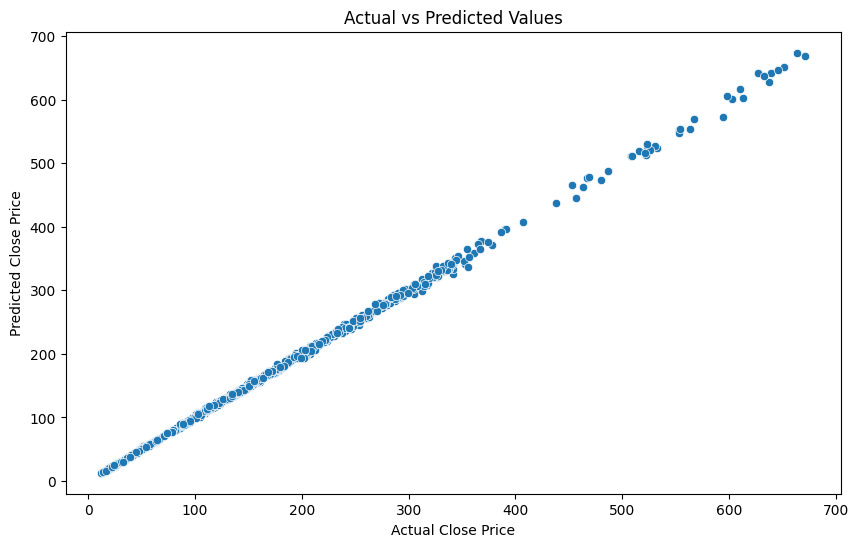

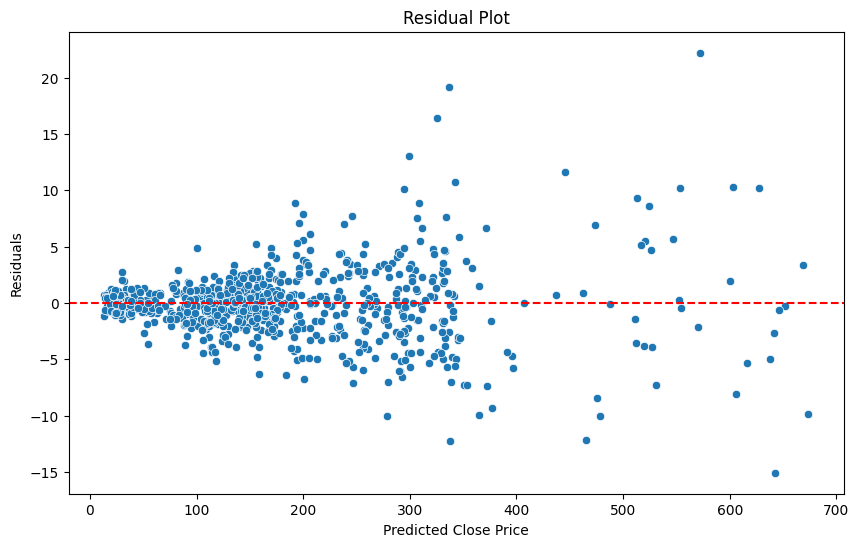

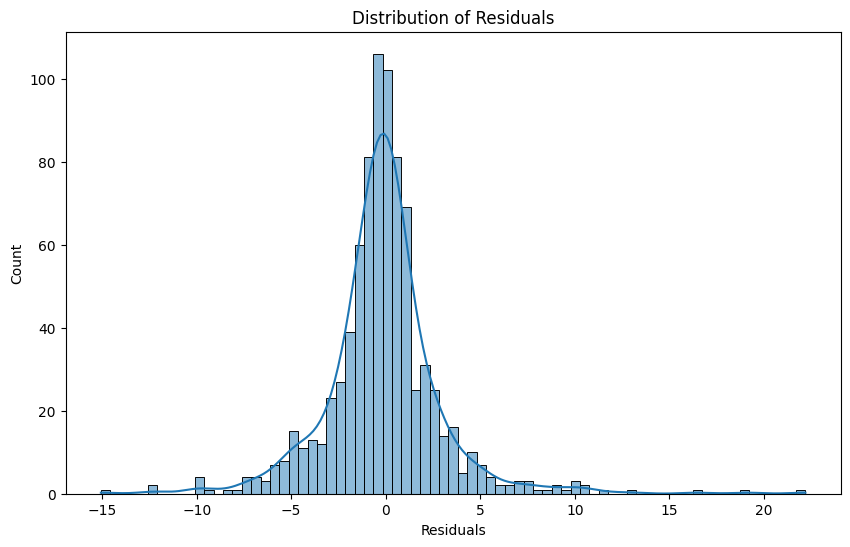

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Assuming 'predictions' contains your model predictions on the test set

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Close Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()
